<p align = "center" draggable=”false”><img src="https://app.vpi.pvn.vn/vpioffice/Styles/Images/logo_VPI_1.jpg"
     width="100px"
     height="auto"/>
</p>
<p align="center" draggable=”false”><strong>Vietnam Petroleum Institute</strong></p>

# Fracture Prediction with support by SHAP and Clustering

In this notebook we will to build and train a ML model to predict whether fracture zone will exist or does not. This is the supervised binary classification problem with output will be 1 (fracture) or 0 (non fracture) so the label is `FRACTURE_ZONE`.

The data source has been provided by `Expert Team` who has deep understanding and multiple works on this field.

The features of this problem as recommended are: `TGAS`, `ROP`, `WOB`, `TORQUE`, `FLWpmps`, `SPP`, `OIL_SHOW`, `DCALI_FINAL`, `DXC`, `RPM`.

The expected model outcome has an accuracy at least 80%.

<hr>

## Table of Contents
1. Preparation
2. Load and Explore data
3. Modeling
4. Model Explaination
5. Export results

## Preparation

We need the following libraries for modeling:

In [1]:
import os
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.cluster import DBSCAN
import fasttreeshap as fshap
import umap

# set seed
seed = 42

import warnings
warnings.filterwarnings('ignore')

# set option
pd.options.display.max_columns=100
pd.options.display.max_rows=20
#pd.options.plotting.backend = "plotly"
plt.style.use(style='ggplot')


/Users/nguyens/miniforge3/envs/nguyensflow/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load and Explore data

In [2]:
# load data
path = '../data/220718-newdata.csv'
df = pd.read_csv(filepath_or_buffer=path, delimiter=',')
df.head()


,DEPT,BASEMENT,DCALI_FINAL,DXC,FLWPMPS,FRACTURE_ZONE,OIL_SHOW_REPORT,ROP,RPM,SPP,TGAS,TORQUE,WELL,WOB
0,3411.1692,0.0,0.548581,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,01-97-HXS-1X,NaN
1,3411.3216,0.0,0.459675,NaN,NaN,NaN,0.0,NaN,NaN,NaN,2271.391113,NaN,01-97-HXS-1X,NaN
2,3411.4740,0.0,0.452804,NaN,NaN,NaN,0.0,NaN,NaN,NaN,2071.391113,NaN,01-97-HXS-1X,NaN
3,3411.6264,0.0,0.475140,NaN,556.0,NaN,0.0,5.9,157.0,NaN,2000.000000,3170.0,01-97-HXS-1X,16.370001
4,3411.7788,0.0,0.483100,NaN,556.0,NaN,0.0,5.9,157.0,NaN,2000.000000,3170.0,01-97-HXS-1X,16.370001


**Statistic Summary**:

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DEPT,123023.0,4517.950898,819.429090,3260.293200,3923.080800,4335.475200,4905.298800,7299.350400
BASEMENT,123023.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DCALI_FINAL,83856.0,0.246285,0.339209,-0.855993,0.092064,0.170200,0.286327,8.371067
DXC,110846.0,13.837646,332.782240,0.000000,1.612304,1.768475,1.902279,39135.691406
FLWPMPS,122990.0,479.973560,92.781905,0.000000,450.000000,500.000000,543.000000,938.000000
...,...,...,...,...,...,...,...,...
RPM,121597.0,171.977989,25.295113,0.000000,157.983994,175.000000,187.000000,291.664001
SPP,117301.0,2713.925552,655.049044,0.000000,2145.800049,2641.343994,3176.507080,4253.576172
TGAS,100151.0,3111.253026,17805.234174,0.000000,0.000000,3.000000,1636.000000,808797.187500
TORQUE,121597.0,14227.858641,10780.047210,0.000000,5423.866211,13701.919922,21524.880859,43124.496094


**Count NaN value**:

[Text(0.5, 1.0, 'Fraction of NaN in each Well')]

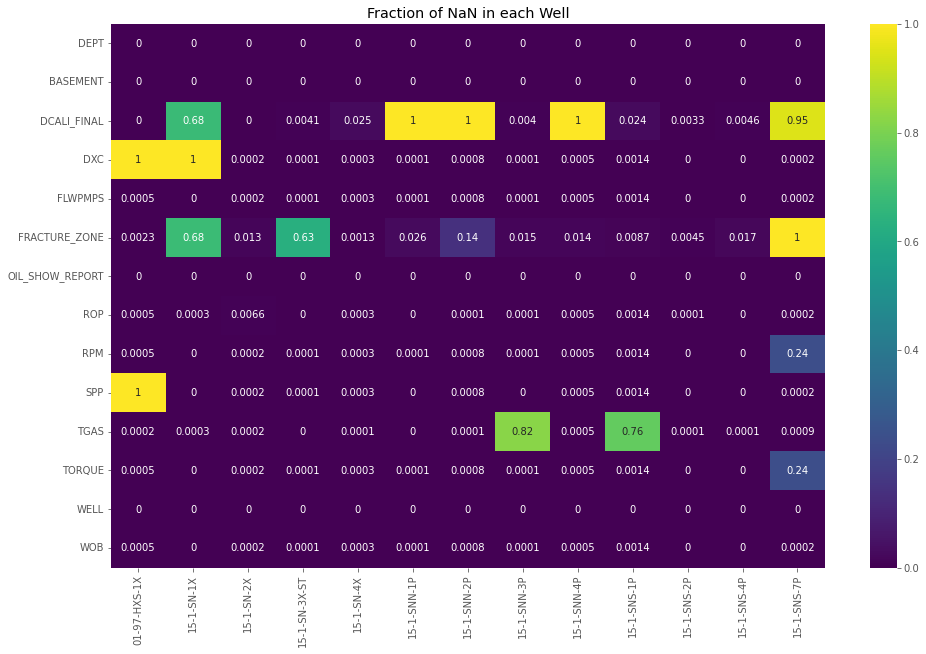

In [4]:
count_nan = np.zeros((df.shape[1], len(df.WELL.unique())))
for i, well in enumerate(df.WELL.unique()):
    df_well = df[df.WELL==well]
    well_count = np.round(df_well.isna().sum()/len(df_well), 4)
    count_nan[:, i] = well_count

# convert to dataframe
count_results = pd.DataFrame(count_nan, index=df.columns, columns=df.WELL.unique())
plt.figure(figsize=(16,10))
sns.heatmap(count_results, annot=True, cmap='viridis').set(title="Fraction of NaN in each Well")


Features: `WOB`, `TORQUE`, `TGAS`, `SPP`, `RPM`, `ROP`, `FLWPMPS`

WELL: `HXS-1X` to be removed


In [5]:
df.WELL.unique()

array(['01-97-HXS-1X', '15-1-SN-1X', '15-1-SN-2X', '15-1-SN-3X-ST',
       '15-1-SN-4X', '15-1-SNN-1P', '15-1-SNN-2P', '15-1-SNN-3P',
       '15-1-SNN-4P', '15-1-SNS-1P', '15-1-SNS-2P', '15-1-SNS-4P',
       '15-1-SNS-7P'], dtype=object)

[Text(0.5, 1.0, 'Correlation matrix')]

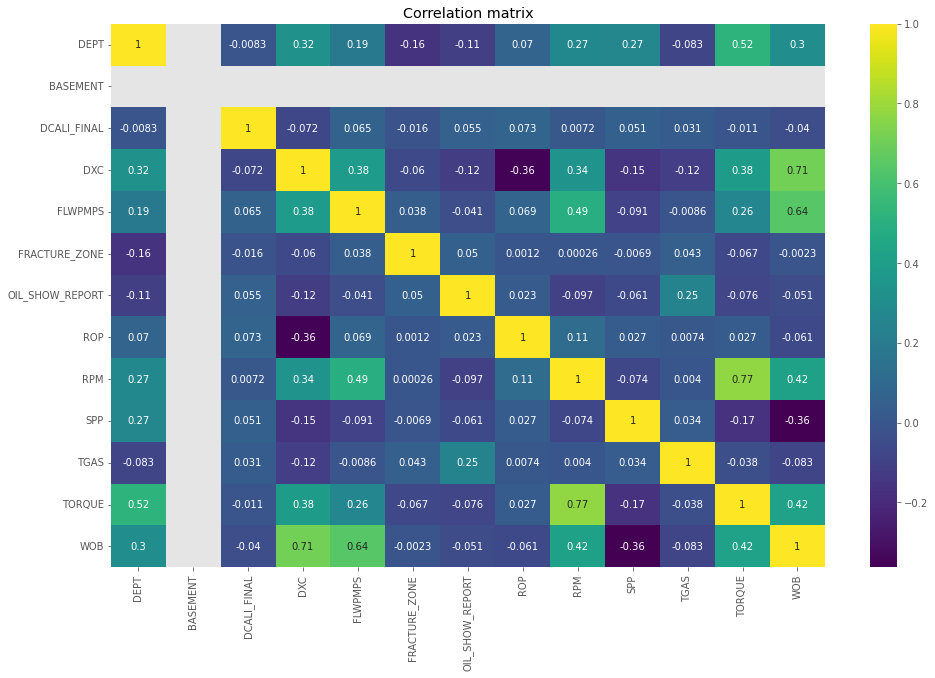

In [6]:
df_reduced = df[df.WELL.isin(['15-1-SN-2X', '15-1-SN-3X-ST', '15-1-SN-4X', '15-1-SNS-2P', '15-1-SNS-4P'])]
plt.figure(figsize=(16,10))
sns.heatmap(df_reduced.corr(method='pearson'), annot=True, cmap='viridis').set(title="Correlation matrix")


In [7]:
df_reduced.FRACTURE_ZONE.value_counts() / len(df_reduced)

0.0    0.651449
1.0    0.158734
Name: FRACTURE_ZONE, dtype: float64

Plot numeric data:

<AxesSubplot:xlabel='RPM', ylabel='ROP'>

<Figure size 432x288 with 0 Axes>

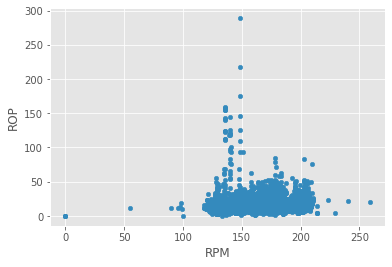

In [8]:
plt.figure();
df_reduced.plot(x='RPM', y='ROP', kind='scatter')


**TGAS, TORQUE and SPP**

<AxesSubplot:xlabel='TGAS', ylabel='TORQUE'>

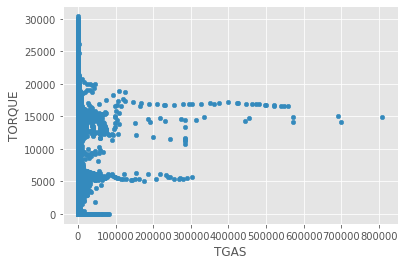

In [9]:
df_reduced.plot(x='TGAS', y='TORQUE', kind='scatter')

<AxesSubplot:xlabel='TORQUE', ylabel='SPP'>

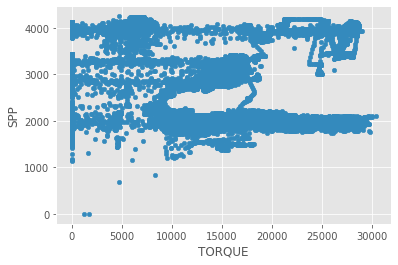

In [10]:
df_reduced.plot(x='TORQUE', y='SPP', kind='scatter')


<AxesSubplot:xlabel='FLWPMPS', ylabel='SPP'>

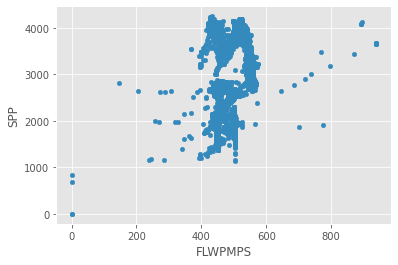

In [11]:
df_reduced.plot(x='FLWPMPS', y='SPP', kind='scatter')


<AxesSubplot:xlabel='WOB', ylabel='SPP'>

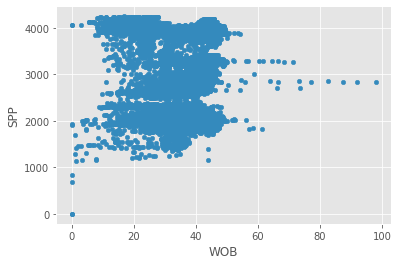

In [12]:
df_reduced.plot(x="WOB", y='SPP', kind="scatter")

Processing data to firstly remove nonsense value:

In [13]:
df_reduced = (
    df_reduced[(df_reduced.FLWPMPS>=50) & \
               (df_reduced.RPM>=100) & \
               (df_reduced.ROP>=1) & \
               (df_reduced.WOB>=4) & \
               (df_reduced.FLWPMPS <=600)
              ]
)

# create new features
df_reduced['spp/depth'] = df_reduced.SPP.values / df_reduced.DEPT.values
df_reduced['torque/rpm'] = df_reduced.TORQUE.values / df_reduced.RPM.values


**Plot new features**

<AxesSubplot:xlabel='spp/depth', ylabel='torque/rpm'>

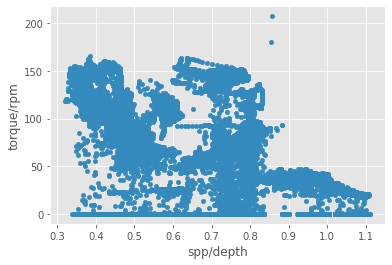

In [14]:
df_reduced.plot(x='spp/depth', y='torque/rpm', kind='scatter')


In [15]:
columns = ["FLWPMPS", "ROP", "SPP", "TGAS", "spp/depth", \
           "torque/rpm", "FRACTURE_ZONE"]
mean_ = df_reduced[columns].mean(axis=0)
std_ = df_reduced[columns].std(axis=0)
min_ = df_reduced[columns].min()
max_ = df_reduced[columns].max()


<AxesSubplot:>

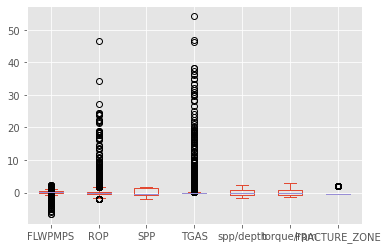

In [16]:
df_reduced_ = df_reduced[columns]
df_scaled = np.zeros(df_reduced_.shape)
for col in range(len(columns)):
    df_scaled[:, col] = (df_reduced_.iloc[:, col] - mean_[col]) / std_[col]
df_scaled = pd.DataFrame(df_scaled, columns=columns)
df_scaled.plot.box()


<AxesSubplot:>

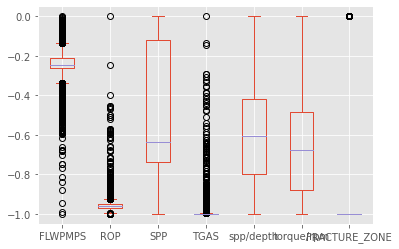

In [17]:
df_reduced_ = df_reduced[columns]
df_scaled = np.zeros(df_reduced_.shape)
for col in range(len(columns)):
    df_scaled[:, col] = (df_reduced_.iloc[:, col] - max_[col]) / (max_[col] - min_[col])
df_scaled = pd.DataFrame(df_scaled, columns=columns)
df_scaled.plot.box()

`ROP` seems to have lot of outliers for above region. Let's try to set a threshold of 50.

In [18]:
df_reduced_cut = df_reduced[df_reduced.ROP <50]


**Let Split data for further study**

In [19]:
from sklearn.model_selection import train_test_split
df_reduced_clean = df_reduced.dropna().reset_index(drop=True)
df_train, df_test = train_test_split(df_reduced_clean, train_size=0.9, random_state=seed)
df_train, df_valid = train_test_split(df_train, train_size=0.9, random_state=seed)


In [20]:
# check len
assert len(df_reduced_clean) == (len(df_train) + len(df_valid) + len(df_test))
print("Done!")

Done!


**Build model**

In [42]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
#scaler = MinMaxScaler()
transformer = Pipeline(
    steps=[
        ('over', SMOTE(sampling_strategy=0.35, k_neighbors=100)),
        ('under', RandomUnderSampler(sampling_strategy=0.5)),
        #('scaler', QuantileTransformer(n_quantiles=100))
    ]
)

# define feature and labels
feature_names = ["DXC", "DCALI_FINAL", "FLWPMPS", "ROP", "TGAS", "SPP", 
                 "spp/depth", "torque/rpm"]
labels = "FRACTURE_ZONE"

# transform
Xtrain, ytrain = df_train[feature_names], df_train[labels]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xtrain = scaler.fit_transform(df_train[feature_names])
Xvalid = scaler.transform(df_valid[feature_names])
Xtest = scaler.transform(df_test[feature_names])


In [43]:
# build model
param = {
    'verbosity': 0,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'learning_rate':0.15,
    'random_state':42,
}

model = xgb.XGBClassifier(**param)
model.fit(Xtrain, df_train[labels])
model.save_model('../saved_models/shap_xgbmodel.model')

**SHAPLEY**

In [44]:
explainer = fshap.TreeExplainer(model, algorithm='auto', n_jobs=4)

Plot:

Training data

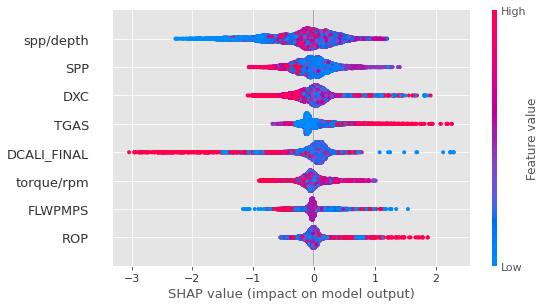

In [45]:
shap_values_train = explainer(Xtrain).values
fshap.summary_plot(shap_values_train, features=Xtrain, feature_names=feature_names)


Validation

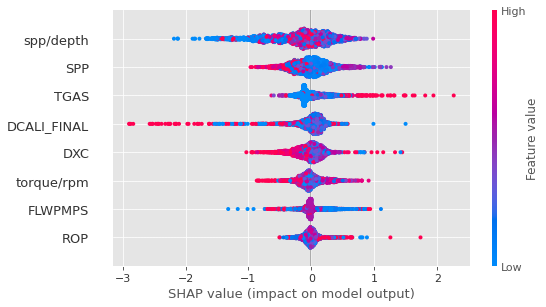

In [46]:
shap_values_valid = explainer(Xvalid).values
fshap.summary_plot(shap_values_valid, features=Xvalid, feature_names=feature_names)


Test

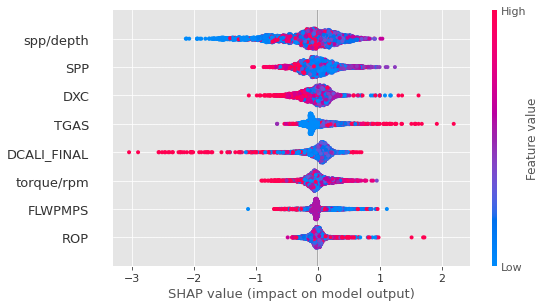

In [47]:
shap_values_test = explainer(Xtest).values
fshap.summary_plot(shap_values_test, features=Xtest, feature_names=feature_names)


Perform umap with shap

In [48]:
import umap
dftrain_2d = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0, random_state=42).fit_transform(Xtrain)
shapvalues_2d = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0).fit_transform(shap_values_train)


<AxesSubplot:>

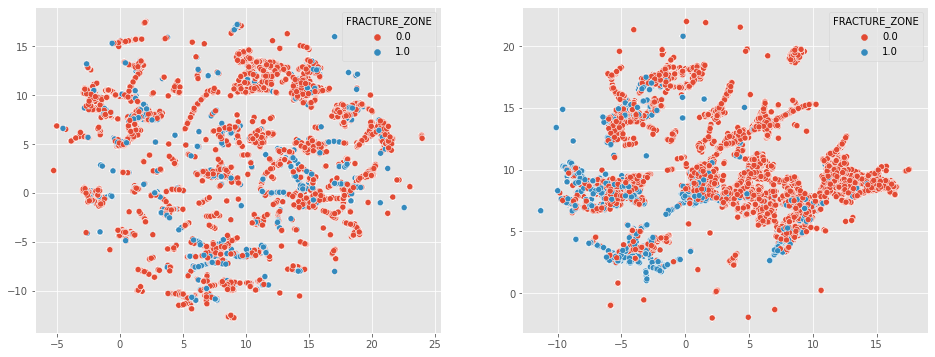

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.scatterplot(x=dftrain_2d[:, 0], y=dftrain_2d[:, 1], hue=df_train[labels], ax=ax[0])
sns.scatterplot(x=shapvalues_2d[:, 0], y=shapvalues_2d[:, 1], hue=df_train[labels], ax=ax[1])


In [50]:
model.score(Xtrain, df_train[labels])


0.846146463192245

Refit model with reduced dataset

In [51]:
model.fit(dftrain_2d, df_train[labels])
model.score(dftrain_2d, df_train[labels])

0.8322295805739515

Refit model by shapvalues

In [52]:
model.fit(shapvalues_2d, df_train[labels])
model.score(shapvalues_2d, df_train[labels])

0.863646543174329

Roughly 10% error rate reduction with Shap and unsupervised learning.

**Change Log**

| No. | Revision | Issue By | Description | Date |
| --- | -------- | -------- | ----------- | ---- |
| 0 | 0 | NguyenS | First issue | 22-08-20 |

**Copyright by VPI&reg;**